In [1]:
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
from torch.utils.data import DataLoader

In [2]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.model_list = self.get_models(root)
        self.files_A = []
        self.files_B = []
        self.get_AB(root)
        
    def get_models(self, root):
        return os.listdir(root)
    
    def get_AB(self, root):
        for model in self.model_list:
            path_model = os.path.join(root, model)
            for img in os.listdir(path_model):
                if "depth" in img:
                    self.files_A.append([os.path.join(path_model, img), os.path.join(path_model, img.replace("depth", "normal"))])
                if "albedo" in img:
                    self.files_B.append(os.path.join(path_model, img))
                

    def __getitem__(self, index):
        item_A_depth = self.transform(Image.open(self.files_A[index % len(self.files_A)][0]).convert("RGB"))
        item_A_normal = self.transform(Image.open(self.files_A[index % len(self.files_A)][1]).convert("RGB"))
        item_A = torch.cat((item_A_depth, item_A_normal), 0)

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert("RGB"))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]).convert("RGB"))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


In [3]:
transforms_ = [ transforms.Resize(int(256*1.12), Image.BICUBIC),
                transforms.RandomCrop(256),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor() ]

dataset = ImageDataset("E:\data_cycleGAN", transforms_=transforms_)
loader = DataLoader(dataset)

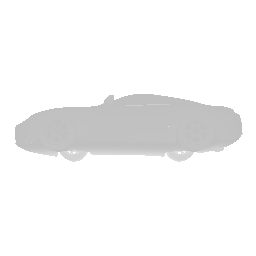

In [4]:
Image.open(dataset.files_A[0][0]).convert("LA")

In [5]:
import matplotlib.pyplot as plt
for batch in loader:
    print(batch["A"].shape)
    print(batch["B"].shape)
    break

torch.Size([1, 6, 256, 256])
torch.Size([1, 3, 256, 256])
